In [1]:
# The import order is important
import matplotlib as mpl
mpl.use('cairo') 
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import graph_tool.all as gt
import numpy as np
from numpy.random import seed, random, randint, uniform
import scipy
from scipy.stats import norm

In [3]:
def create_model_graph():
    g = gt.Graph(directed=False)
    # nodes represent people
    # edges represent 'knowing' relationships of people

    # friendliness:  # or g.ep.friendliness
    #   -1 if people are enemies
    #   +1 if people are friends'
    g.edge_properties["friendliness"] = g.new_edge_property("double")

    # each person has a prior distr, mean and std
    # or g.vp.prior_mean and g.vp.prior_sd
    g.vertex_properties["prior_mean"] = g.new_vertex_property("double")
    g.vertex_properties["prior_sd"] = g.new_vertex_property("double")
    g.vertex_properties["prior_distr"] = g.new_vertex_property("vector<double>")

    return g

In [5]:
def draw_graph(g, show_vertex_labels=False, width=150):

    edge_color_map = {-1: (1, 0, 0, 1), 1: (0, 1, 0, 1)}
    edge_colors = [edge_color_map[e] for e in g.ep.friendliness]

    gt.graph_draw(g, 
                  vertex_text=g.vertex_index if show_vertex_labels else None,
                 # edge_color=edge_colors,
                  edge_text=g.ep.friendliness, 
                  output_size=(width,width))

In [28]:
ADJ_FRIEND = 1
ADJ_ENEMY = -1

def add_relationship(g, v1, v2, friendliness):
    e = g.add_edge(v1, v2) # they know each other

    g.ep.friendliness[e] = friendliness  # if they like each other

def add_friends(g, v1, v2):
    add_relationship(g, v1, v2, ADJ_FRIEND)

def add_enemies(g, v1, v2):
    add_relationship(g, v1, v2, ADJ_ENEMY)

In [9]:
def create_pair():
    """
    Creates graph of 2 nodes and one edge.
    """
    g = create_model_graph()

    v1 = g.add_vertex()
    v2 = g.add_vertex()
    e = g.add_edge(v1, v2)

    g.ep.adj[e] = ADJ_FRIEND

    return g

# non-biased - theta = 0.5



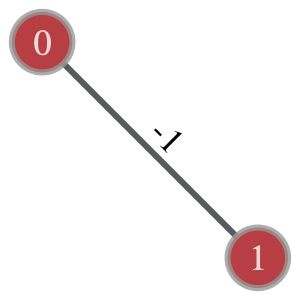

In [10]:
g = create_model_graph()

v1, v2 = g.add_vertex(2)

add_enemies(g, v1, v2)

draw_graph(g, show_vertex_labels=True)

In [11]:
seed(42)

In [12]:
HEADS = 1  # "success" is for the coin to land heads
TAILS = 0
# a Ber(0.5) trial
def toss_coin():
    return randint(0, 2)



In [13]:
def bias():
    # discretise the continuous variable theta (bias) into 21 regularly-spaced
    # values  (0.00, 0.05, ..., 1.00)
    return np.linspace(0, 1, 21)

def bias_mat(num_priors):
    # generate matrix of num_prior rows and 
    # 21 columns (bias() for each row of the matrix)
    return np.tile(bias(), (num_priors, 1))

def fwhm_to_sd(fwhm):
    # full width half mean
    # 2 * sqrt(2 * ln(2))  (see wiki) (don't calculate sqrt or ln)
    return fwhm / 2.3548200450309493820231386529

def generate_priors(num_priors, mean_range=(0.0, 1.0), fwhm_range=(0.2, 0.8)):
    prior_mean = uniform(*mean_range, num_priors)
    prior_fwhm = uniform(*fwhm_range, num_priors)
    prior_sd = fwhm_to_sd(prior_fwhm)

    return prior_mean, prior_sd

def prior_distr(prior_mean, prior_sd):
    return norm.pdf(bias(), loc=prior_mean, scale=prior_sd)

def prior_distr_vec(num_priors, prior_mean, prior_sd):
    # ensure norm.pdf behaves (broadcasting - scipy)
    prior_mean.shape = prior_sd.shape = (num_priors, 1)
    return norm.pdf(bias_mat(num_priors), loc=prior_mean, scale=prior_sd)


In [14]:
def run_simulation(g, max_steps=1e4):
    """
    max_steps (T in the paper) - maximum number of steps to run the simulation
    """
    # steps 2-3 of Probabilistic automaton, until t = T
    for t in range(max_steps):
        step_simulation(g)



In [15]:
def likelihood_fn(state, bias):
    """
    state: coin toss value (TODO generalise)
    bias: θ, the value for the bias
    The likelihood encodes the probability of observing a heads, given θ
    """
    if state == 0:
        return bias
    return 1 - bias

In [16]:
def coin_toss_likelihood():
    """
    coin toss likelihood - encodes the probability of observing a heads, given bias θ
    only 2 possible outcomes in a coin toss:
    row 0 (tails) : 1 - θ
    row 1 (heads) : θ 
    """
    return np.array((1 - bias(), bias()))

In [17]:
def normalising_constant_i(likelihood, prior_distr):
    """
    sum_θ{  P(S(T) | θ) * x_i (t, θ)    }
    """
    return np.sum(likelihood * prior_distr, axis=1)


In [18]:
def normalising_constant(likelihood, graph_prior_distr):
    """
    value i is normalising constant for node / person i
    sum_θ{  P(S(T) | θ) * x_i (t, θ) }
    """
    # for 1 person
    if len(graph_prior_distr.shape) == 1:
        return np.sum(np.matmul(likelihood, graph_prior_distr))

    # ensure the prior distribution has the right shape
    if likelihood.shape[1] == graph_prior_distr.shape[1]:
        graph_prior_distr = graph_prior_distr.T
    return np.sum(np.matmul(likelihood, graph_prior_distr), axis=1)

In [19]:
def debug_state(g):
    verts = g.iter_vertices([g.vp.prior_mean, g.vp.prior_sd, g.vp.prior_distr])
    for v, prior_mean, prior_sd, prior_distr in verts:
        print(v, prior_mean, prior_sd, prior_distr)

    plot_distr(g)

def plot_distr(distr, title=None):
    fig, ax = plt.subplots()

    for v, d in enumerate(distr):
        ax.plot(bias(), d, label=str(v))

    ax.set_xlabel(r'Bias, $\theta$')
    ax.set_ylabel('Probability')

    ax.grid(linestyle='--', axis='x')
    ax.set_title(title)
    # plt.tick_params(axis='y', which='both', left=False, right=False, top=False, bottom=False, labelleft=False)
    plt.tight_layout()

def plot_graph_distr(g):
    fig, ax = plt.subplots()

    for v, distr in g.iter_vertices([g.vp.prior_distr]):
        ax.plot(bias(), distr, label=str(v))

    ax.set_xlabel(r'Bias, $\theta$')
    ax.set_ylabel('Probability')

    ax.grid(linestyle='--', axis='x')
    # plt.tick_params(axis='y', which='both', left=False, right=False, top=False, bottom=False, labelleft=False)
    plt.tight_layout()


In [20]:
def graph_get_prior_distr(g):
    """
    Returns matrix: 
        row i corresponding to the prior distribution for person i, x_i(t, θ)
        col j corresponding to the prior distribution evaluated at θ = 0.05 * j
    """
    return g.vp.prior_distr.get_2d_array(np.arange(21)).T

In [21]:
def init_simulation(g, prior_mean=None, prior_sd=None): # mean_range=(0.0, 1.0), fwhm_range=(0.2, 0.8)
    n = g.num_vertices(ignore_filter=True)

    # randomly generate prior and prior sd if no args given
    if prior_mean is None or prior_sd is None:
        prior_mean, prior_sd = generate_priors(n)
        print(prior_mean, prior_sd)
    
    # equivalent to g.vp.prior_mean.get_array()[:]
    g.vp.prior_mean.a = prior_mean
    g.vp.prior_sd.a = prior_sd

    # transpose is O(1) !!!
    distr = prior_distr_vec(n, prior_mean, prior_sd).T
    # required for indirect array access of vector
    g.vp.prior_distr.set_2d_array(distr)
    
    # print(g.vp.prior_distr.get_2d_array(np.arange(21)).T)
    """
    #  iteration might be slow for enumeration
    for v in g.iter_vertices():
        g.vp.prior_distr.a = distr[v]
    """
    

In [22]:
def step_simulation(g, true_bias=0.5, learning_rate=0.25):
    """
    true_bias (θ_0 in the paper)
    learning_rate (μ / μ_i in the paper)
    TODO later: learning_rate can be a vector, length # nodes
        sets a learning rate for each person in the graph.
    """
    ## simulate an independent coin toss
    toss = toss_coin()

    ## update the opinions of each agent according to Bayes' Theorem (observe coin toss)
    prior_distr = graph_get_prior_distr(g)
    norm_const = normalising_constant(coin_toss_likelihood(), prior_distr)
    likelihood = coin_toss_likelihood()[toss]    # (eqn 2)
    # Fix some broadcasting issue https://stackoverflow.com/questions/19602187/numpy-divide-each-row-by-a-vector-element
    posterior_distr = likelihood * prior_distr / norm_const[:,None]  # (eqn 1)
    # Rows: node i's posterior distribution.  Cols: posterior distr evaluated at theta

    ## Mix the opinions of each node with respective neighbours (eq 3,4)
    avg_dist_in_belief = avg_dist_in_belief(g, posterior_distr)

    next_dist = posterior_distr + avg_dist_in_belief * learning_rate

    # TODO: use np.amax to find max
    # TODO: calculate proportionality constant by eqn 3


In [23]:
init_simulation(g, np.array((0.25, 0.75)), np.array([fwhm_to_sd(0.4)] * 2))

In [24]:
def friendliness_mat(g):
    # get the friendliness matrix 
    # (graph_tool internally uses an adjacency list representation, 
    #  need to convert the weight list to a weight matrix; 
    #  rows / cols being neighbouring nodes)
    # laplacian doc: https://graph-tool.skewed.de/static/doc/spectral.html#graph_tool.spectral.laplacian
    friendliness = -gt.laplacian(g, weight=g.ep.friendliness).toarray()
    np.fill_diagonal(friendliness, 0) # diagonals of laplacian are some 'gamma'
    return friendliness

In [25]:
def avg_dist_in_belief(g, posterior):
    n = g.num_vertices(ignore_filter=True)

    friendliness = friendliness_mat(g)

    xi = np.broadcast_to(posterior_distr, (n, n, 21)).transpose((1, 0, 2))
    xj = np.broadcast_to(posterior_distr, (n, n, 21))
    # calculate the difference in belief for node i to node j
    diff_in_belief = ((xj - xi).T * friendliness).T
    summation = np.sum(diff_in_belief, axis=1)

    # sums over the columns
    divisor = np.reciprocal(np.sum(np.abs(friendliness), axis=1))

    # the .T stuff fixes some broadcasting issue  (same above too!)
    avg_dist_in_belief = (summation.T * divisor).T
    return avg_dist_in_belief

In [26]:
# OLD VERSION!
adj = gt.adjacency(g).todense()
xj = np.matmul(adj, posterior_distr)
xi = posterior_distr
diff_in_belief = xj - xi
diff_in_belief = np.broadcast_to(interactions, (n, n, 21))

friendliness = -gt.laplacian(g, weight=g.ep.friendliness).toarray()
np.fill_diagonal(friendliness, 0) # diagonals of laplacian are some 'gamma'

# sums over the columns
divisor = np.reciprocal(np.sum(np.abs(friendliness), axis=1))

# don't know how else to do this one, it would be nice if we didn't need
# to do this (particularly the [0] at the end!)
avg_dist_in_belief = np.tensordot(friendliness, interactions, axes=1)[0] * divisor


NameError: name 'posterior_distr' is not defined

In [451]:
# TEST VERSION!
i = 1
j = 0
del_x1 = -(posterior_distr[j] - posterior_distr[i])
del_x0 = -(posterior_distr[i] - posterior_distr[j])
res = np.array([del_x0, del_x1])
res

array([[-6.67618732e-04, -8.13365332e-07,  8.33944117e-02,
         9.76908806e-02,  1.04400396e-01,  1.01498975e-01,
         8.92073779e-02,  6.98141085e-02,  4.67205163e-02,
         2.32968656e-02,  2.14908355e-03, -1.50036460e-02,
        -2.71006246e-02, -3.35781041e-02, -3.44706453e-02,
        -3.06174679e-02, -2.36552566e-02, -1.56345341e-02,
        -8.40557284e-03, -3.10533038e-03, -0.00000000e+00],
       [ 6.67618732e-04,  8.13365332e-07, -8.33944117e-02,
        -9.76908806e-02, -1.04400396e-01, -1.01498975e-01,
        -8.92073779e-02, -6.98141085e-02, -4.67205163e-02,
        -2.32968656e-02, -2.14908355e-03,  1.50036460e-02,
         2.71006246e-02,  3.35781041e-02,  3.44706453e-02,
         3.06174679e-02,  2.36552566e-02,  1.56345341e-02,
         8.40557284e-03,  3.10533038e-03, -0.00000000e+00]])

In [27]:
plot_distr(posterior_distr, title="Posterior distr")

NameError: name 'posterior_distr' is not defined

In [107]:
posterior_distr[1]

array([7.24073088e-06, 2.41614436e-05, 7.37275667e-05, 2.05667508e-04,
       5.24284919e-04, 1.22078873e-03, 2.59507795e-03, 5.03280489e-03,
       8.89741011e-03, 1.43239211e-02, 2.09713967e-02, 2.78739963e-02,
       3.35542348e-02, 3.64608900e-02, 3.55896404e-02, 3.09711070e-02,
       2.37264270e-02, 1.56260957e-02, 8.38855870e-03, 3.09711070e-03,
       0.00000000e+00])

In [200]:
posterior_distr.shape

(2, 21)

In [81]:
np.broadcast_to(posterior_distr, (2, 2, 21)) - posterior_distr

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]]])

In [82]:
posterior_distr.shape

(2, 21)

In [108]:
posterior_distr

array([[4.19427935e-02, 5.88451034e-02, 7.54970283e-02, 8.85478758e-02,
        9.49057078e-02, 9.29133211e-02, 8.30424944e-02, 6.77130815e-02,
        5.03313522e-02, 3.40682177e-02, 2.09713967e-02, 1.17195718e-02,
        5.93160674e-03, 2.70997186e-03, 1.11217626e-03, 4.06929576e-04,
        1.31071230e-04, 3.62942660e-05, 8.19195185e-06, 1.27165493e-06,
        0.00000000e+00],
       [7.24073088e-06, 2.41614436e-05, 7.37275667e-05, 2.05667508e-04,
        5.24284919e-04, 1.22078873e-03, 2.59507795e-03, 5.03280489e-03,
        8.89741011e-03, 1.43239211e-02, 2.09713967e-02, 2.78739963e-02,
        3.35542348e-02, 3.64608900e-02, 3.55896404e-02, 3.09711070e-02,
        2.37264270e-02, 1.56260957e-02, 8.38855870e-03, 3.09711070e-03,
        0.00000000e+00]])

In [83]:
[posterior_distr - posterior_distr[0], posterior_distr - posterior_distr[1]]

[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.09583905e-03, -8.38036675e-03,
         -1.55898015e-02, -2.35953557e-02, -3.05641775e-02,
         -3.44774642e-02, -3.37509182e-02, -2.76226281e-02,
         -1.61544245e-02, -6.93889390e-18,  1.97442966e-02,
          4.14339421e-02,  6.26802766e-02,  8.04474164e-02,
          9.16925324e-02,  9.43814229e-02,  8.83422083e-02,
          7.54233007e-02,  5.88209419e-02,  4.19355528e-02]]),
 array([[ 0.00000000e+00,  3.09583905e-03,  8.38036675e-03,
          1.55898015e-02,  2.35953557e-02,  3.05641775e-02,
          3.44774642e-02,  3.3750918

In [68]:
plot_distr(g)

TypeError: 'Graph' object is not iterable

In [69]:
debug_state(g)

0 0.25 0.16986436005760383 array([7.95148841e-01, 1.17429660e+00, 1.59029768e+00, 1.97492360e+00,
       2.24902055e+00, 2.34859320e+00, 2.24902055e+00, 1.97492360e+00,
       1.59029768e+00, 1.17429660e+00, 7.95148841e-01, 4.93730900e-01,
       2.81127569e-01, 1.46787075e-01, 7.02818922e-02, 3.08581813e-02,
       1.24242006e-02, 4.58709609e-03, 1.55302508e-03, 4.82159082e-04,
       1.37269321e-04])
1 0.75 0.16986436005760383 array([1.37269321e-04, 4.82159082e-04, 1.55302508e-03, 4.58709609e-03,
       1.24242006e-02, 3.08581813e-02, 7.02818922e-02, 1.46787075e-01,
       2.81127569e-01, 4.93730900e-01, 7.95148841e-01, 1.17429660e+00,
       1.59029768e+00, 1.97492360e+00, 2.24902055e+00, 2.34859320e+00,
       2.24902055e+00, 1.97492360e+00, 1.59029768e+00, 1.17429660e+00,
       7.95148841e-01])


TypeError: 'Graph' object is not iterable